# pythia-features

In [2]:
import os
from typing import Tuple, List, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import utils, stats

In [3]:
# Knobs
data_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features.csv' # Max pooling
#data_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_sum.csv' # Sum pooling

seed: int = 1337
output_dir: str = './plots/pythia_features'
suites: List[List[str]] = [utils.spec06, utils.spec17, utils.gap]
suite_names: List[str] = ['SPEC 06', 'SPEC 17', 'GAP']
metrics: List[str] = ['ipc_improvement', 'LLC_mpki_reduction', 
                       'L2C_mpki_reduction']

dpi = 120

In [4]:
def load_data(data_path: str) \
    -> Dict[Tuple[str, ...], pd.DataFrame]:
    """Load different feature groupings, as stored in a 
    .csv file generated from the evaluate script in 
    Pythia/experiments.
    """
    data_df = {}
    df = utils.read_data_file(data_path)
    df = df[df.seed == seed]
    features = df.pythia_features.unique()
    for feat in features:
        data_df[', '.join(eval(feat))] = df[df.pythia_features == feat]

    return data_df
    
data_df : dict = load_data(data_path)

---
## Metrics of each static threshold
- How does each static threshold compare to regular Pythia, and no prefetcher?

In [5]:
def plot_metric(dfs: dict, metric: str, 
                dpi: int = None, 
                figsize: Tuple[int, int] = None,
                suite_name: str= None) -> None:
    """Plot the metric between the dfs on each trace
    in a suite.
    """
    match_pref = lambda x : x != ('no', 'no', 'no') # Used in p_samples
    
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    num_samples = len(dfs.items())
    gap = num_samples + 1

    traces = list(list(dfs.values())[0].trace.unique()) + ['mean']
    trace_names = (list(list(dfs.values())[0].trace.unique()) 
                   + (['amean'] if metric in utils.amean_metrics 
                                else ['gmean']))
    largest_y = 0
    for i, (setup, df) in enumerate(dfs.items()):
        df = df[df.pythia_level_threshold == float('-inf')]
        df = stats.add_means(df) # Add mean as an extra trace

        for j, tr in enumerate(traces):
            rows = df[df.trace == tr]
            pos = gap*j + i
            #print(f'[DEBUG] i={i} j={j} setup={setup} tr={tr} pos={pos}, {pos+1}')
            p_samples = (rows[rows.all_pref.apply(match_pref)]
                             [metric])
            p_min, p_mean, p_max = (p_samples.min(), p_samples.mean(), 
                                    p_samples.max())
            
            largest_y = max(largest_y, p_max)
            
            #print(f'[DEBUG] {tr} Regular {setup} {p_mean:.2f} {p_min:.2f} {p_max:.2f}')
            ax.bar(
                pos, p_mean, 
                label=f'{setup}' if j == 0 else None, 
                color=f'C{i}'
            )
            ax.errorbar(
                pos, p_mean, 
                yerr= [[p_mean - p_min], [p_max - p_mean]], 
                color='black'
            )

    ax.set_xticks(
        np.arange(0, len(df.trace.unique())) * gap + (num_samples/2)
    )
    ax.set_xticklabels(trace_names, rotation=90)
    ax.set_xlabel('Trace')

    ax.set_yticks(np.arange(0, round(largest_y, -1) + 10, 10))
    ax.set_ylabel(metric.replace('_', ' ') + ' (%)')
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
        
    #fig.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    fig.legend()
    fig.suptitle(f'{metric.replace("_", " ")} ({suite_name})') \
                 if suite_name is not None \
                 else fig.suptitle(f'{metric.replace("_", " ")}')
    fig.tight_layout()

---
# Different features

In [6]:
os.makedirs(f'{output_dir}/', exist_ok=True)
# os.makedirs(f'{output_dir}/ipc_improvement', exist_ok=True)
# os.makedirs(f'{output_dir}/L2C_mpki_reduction', exist_ok=True)
# os.makedirs(f'{output_dir}/LLC_mpki_reduction', exist_ok=True)

SPEC 06
SPEC 17
GAP


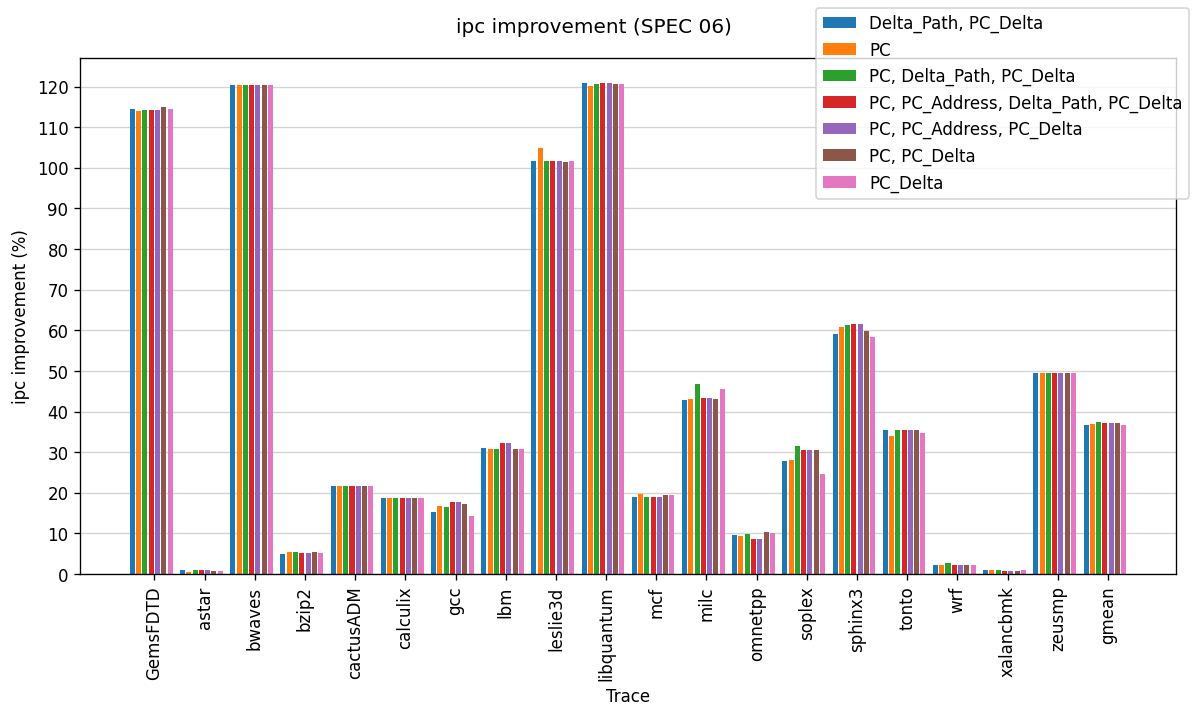

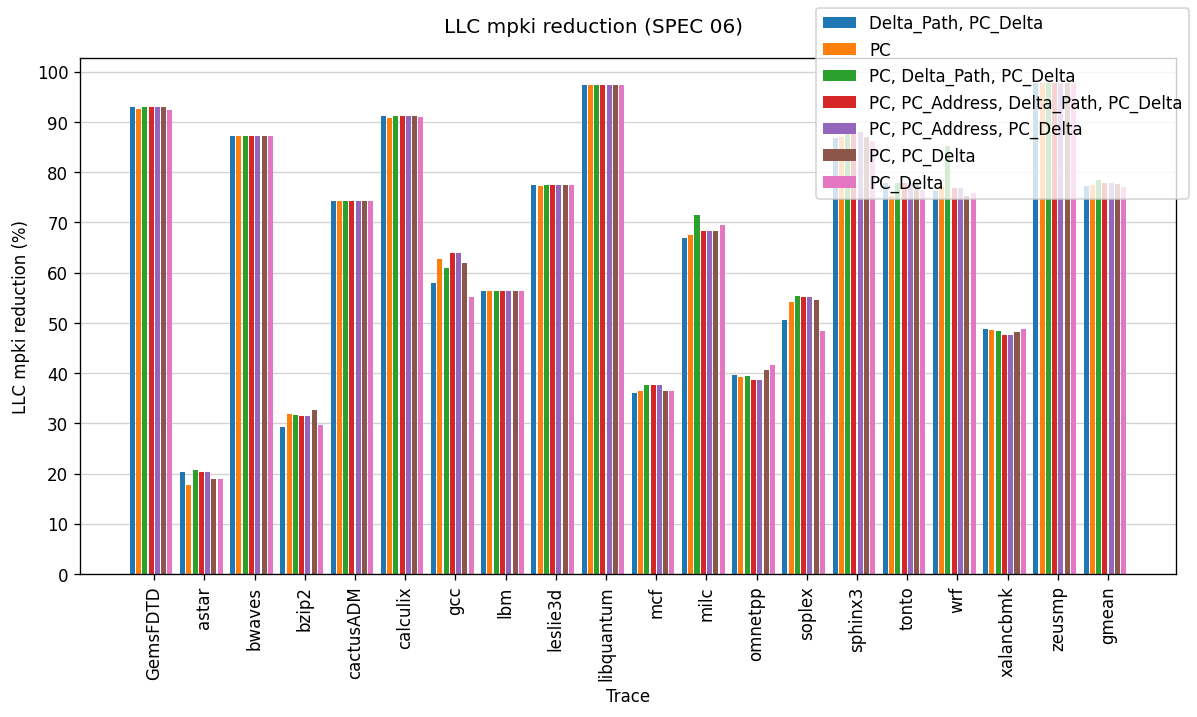

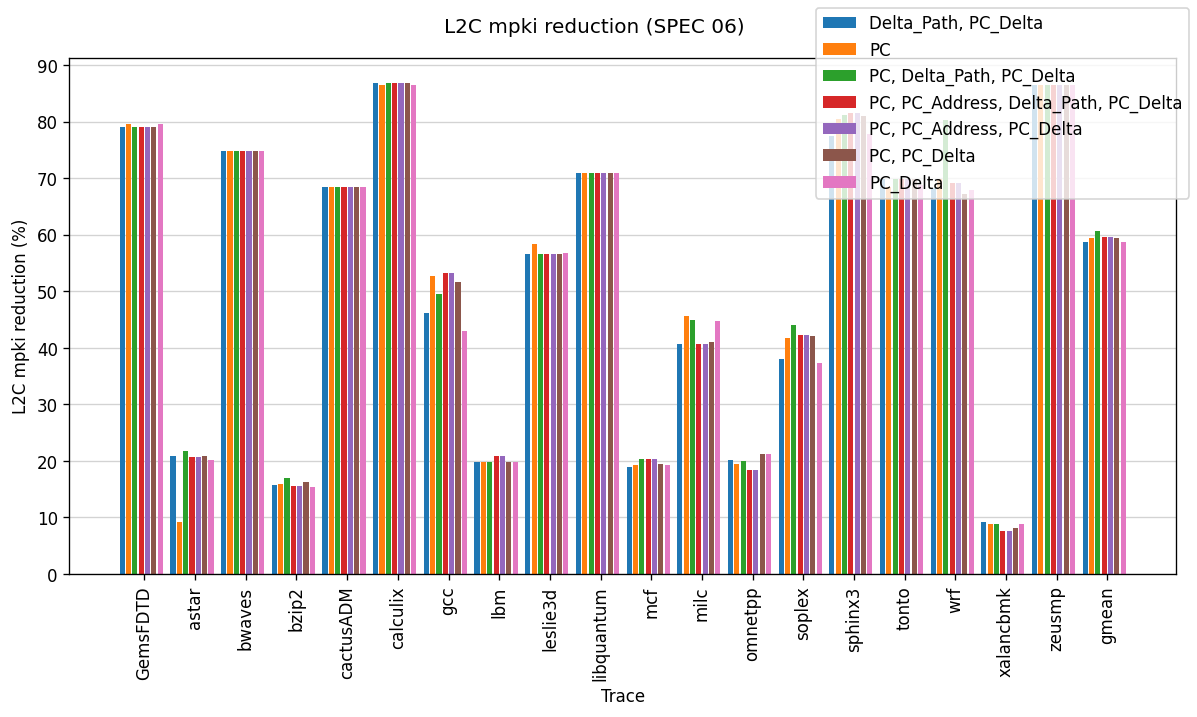

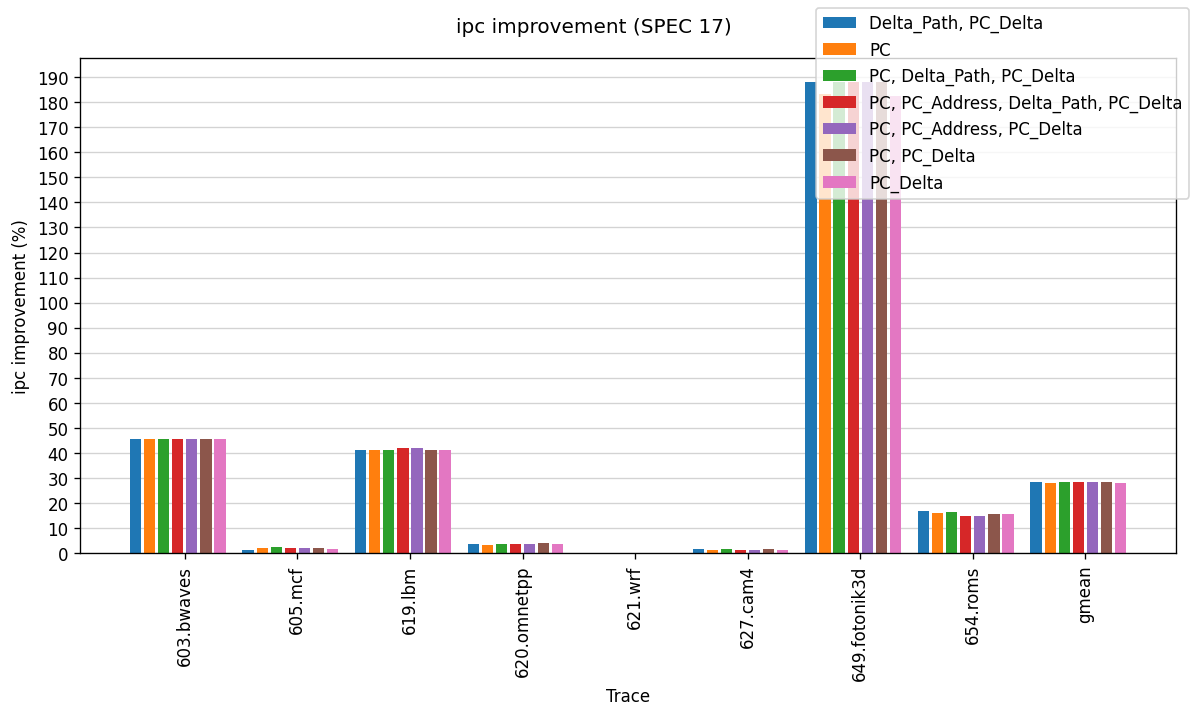

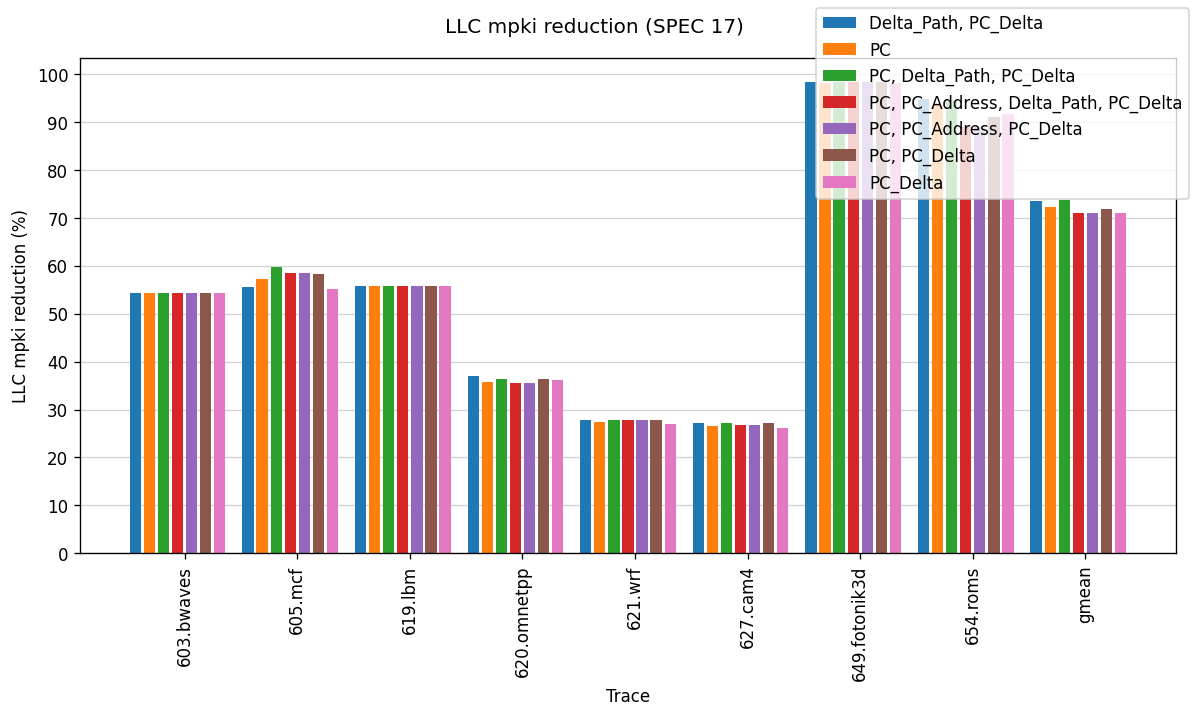

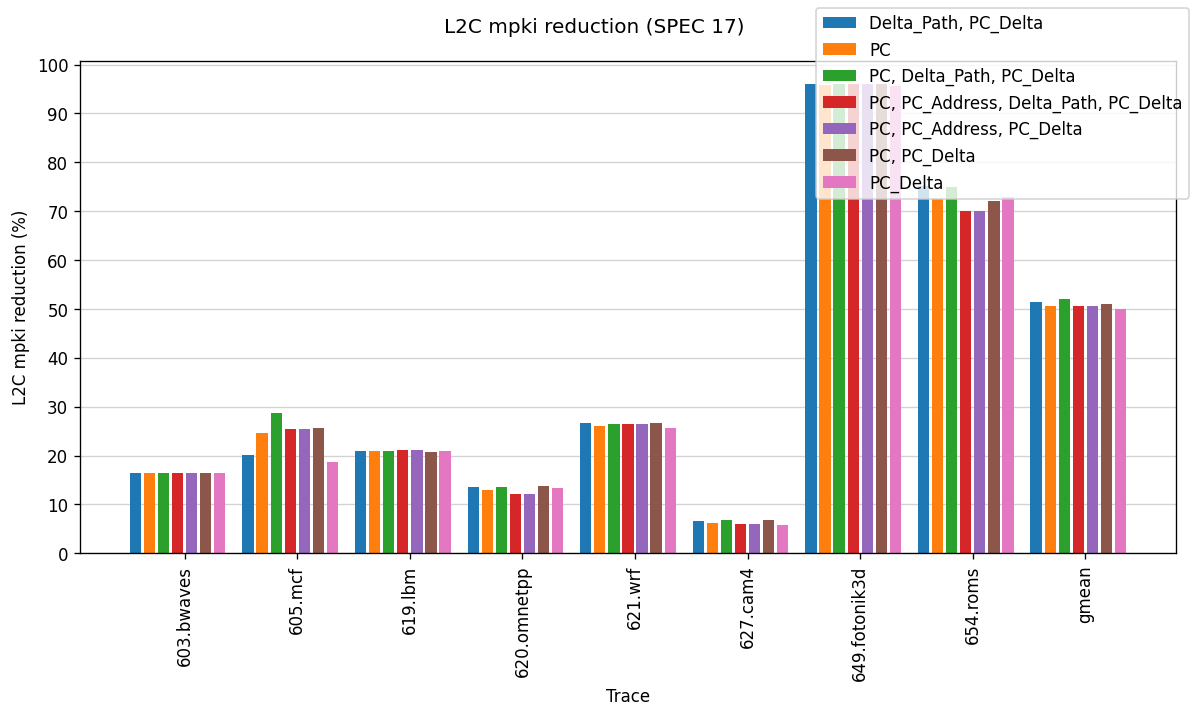

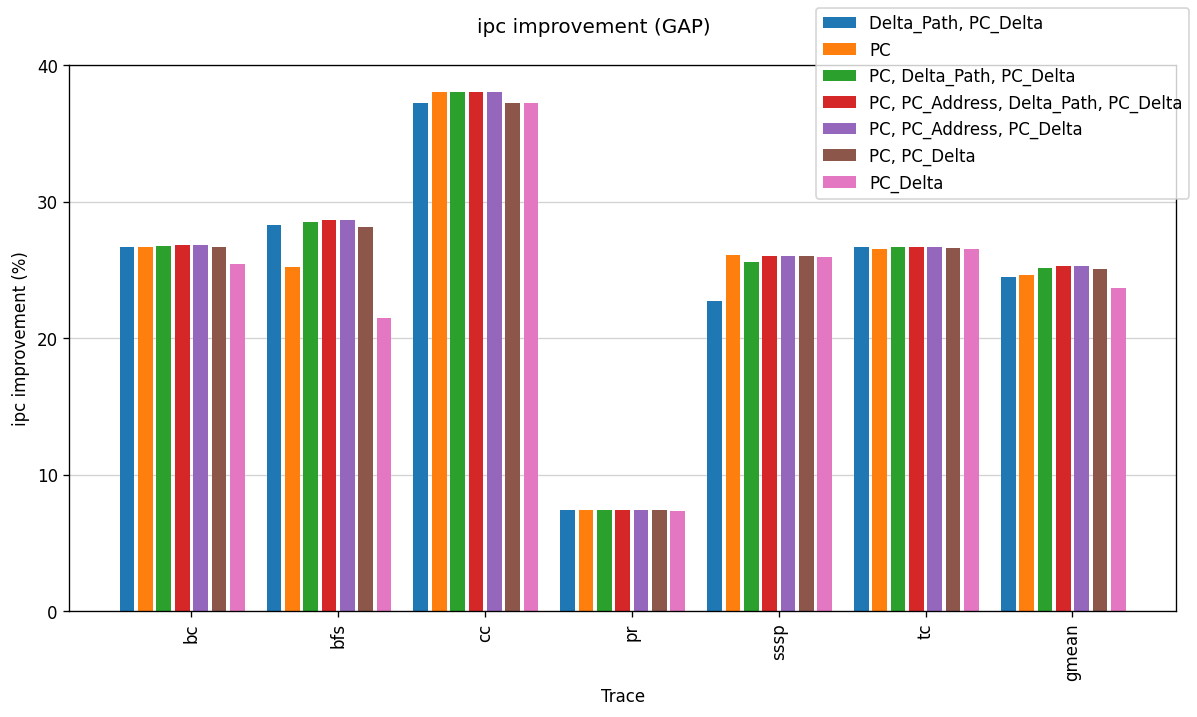

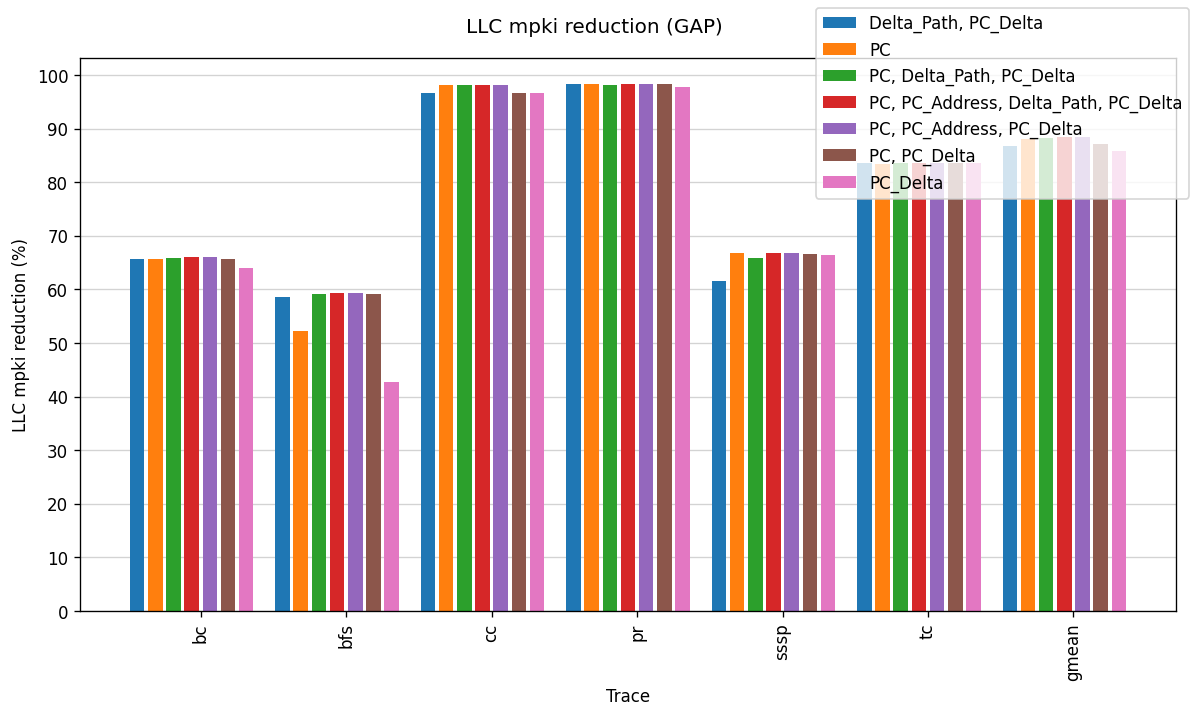

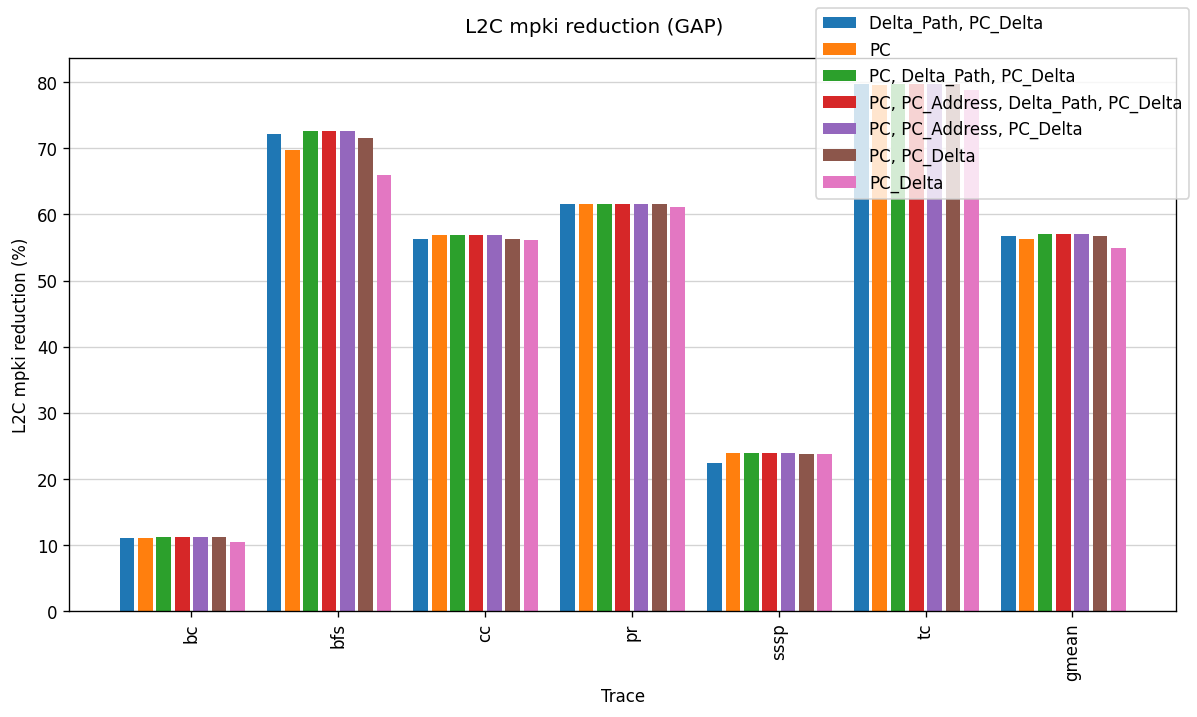

In [7]:
for suite_name, suite in zip(suite_names, suites):
    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    
    print(suite_name)
    for metric in metrics: 
        plot_metric(
            data_df_, metric,
            suite_name=suite_name,
            figsize=(10,6),
            dpi=dpi
        )
        plt.savefig(
            f'{output_dir}/{suite_name}_{metric}.pdf', 
            bbox_inches='tight'
        )

# Baselines

In [8]:
max_pool_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features.csv' # Max pooling
sum_pool_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_sum.csv' # Sum pooling
baseline_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_baseline.csv' # Baselines

In [9]:
def load_data_baseline(max_pool_path, sum_pool_path, baseline_path, 
                       features=('Delta_Path', 'PC_Delta'),
                       baselines=('bingo', 'spp', 'bingo_spp', 'stride')) \
    -> Dict[Tuple[str, ...], pd.DataFrame]:
    """Load different feature groupings for the baseline analysis.
    """
    data_df = {}
    max_df = utils.read_data_file(max_pool_path)
    max_df = max_df[(max_df.seed == seed) & 
                    (max_df.simpoint == 'weighted') &
                    (max_df.pythia_features == str(features))]
    data_df['max'] = max_df

    sum_df = utils.read_data_file(sum_pool_path)
    sum_df = sum_df[(sum_df.seed == seed) & 
                    (sum_df.simpoint == 'weighted') &
                    (sum_df.pythia_features == str(features))]
    data_df['sum'] = sum_df

    base_df = utils.read_data_file(baseline_path)
    base_df = base_df[(base_df.seed == seed) &
                      (base_df.simpoint == 'weighted')]
    # TODO: See why there are NaN baseline metrics. 
    # (fillna is a temporary fix and should be removed, it skews values)
    base_df.fillna(0, inplace=True)
    for pf in baselines:
        data_df[pf] = base_df[base_df.all_pref == ('no', pf, 'no')]

    return data_df
    
data_df : dict = load_data_baseline(max_pool_path, sum_pool_path, baseline_path)
data_df.keys()

dict_keys(['max', 'sum', 'bingo', 'spp', 'bingo_spp', 'stride'])

SPEC 06
SPEC 17
GAP


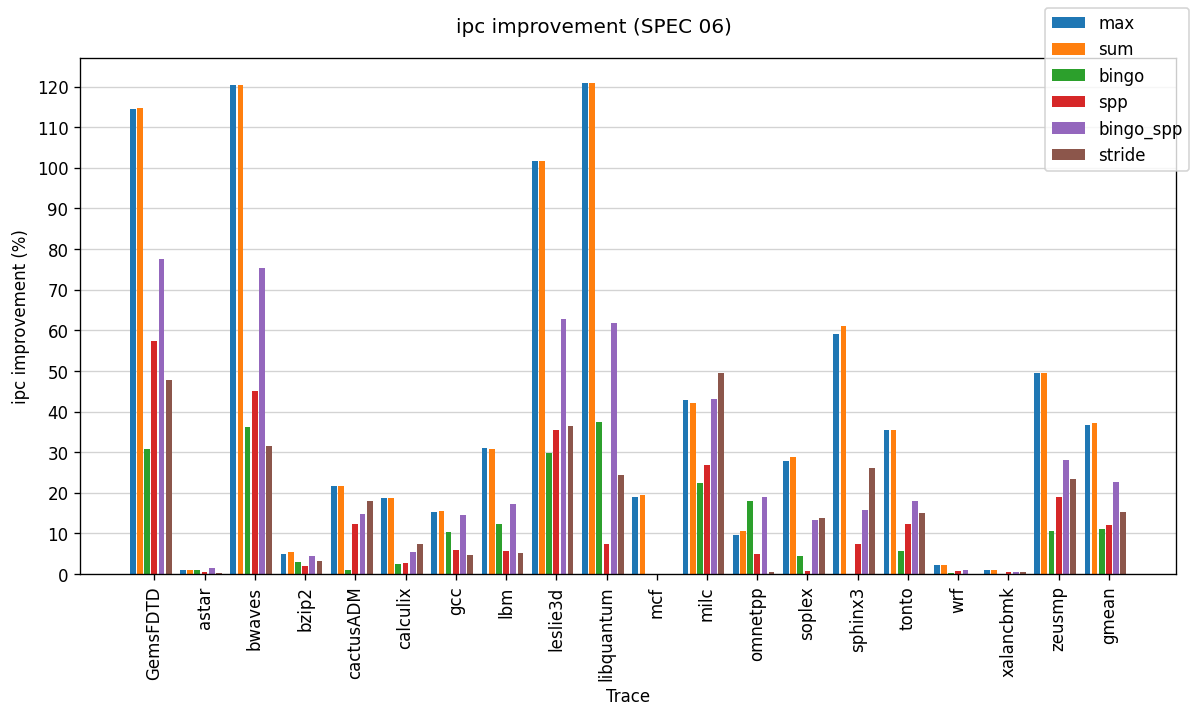

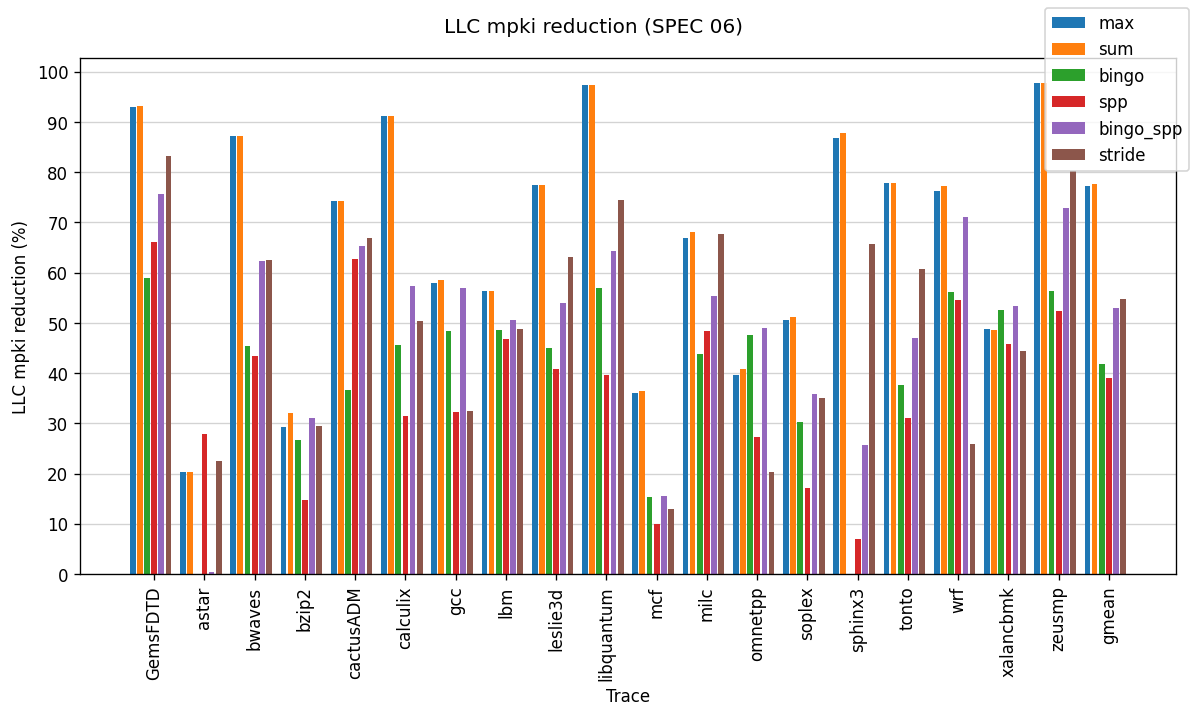

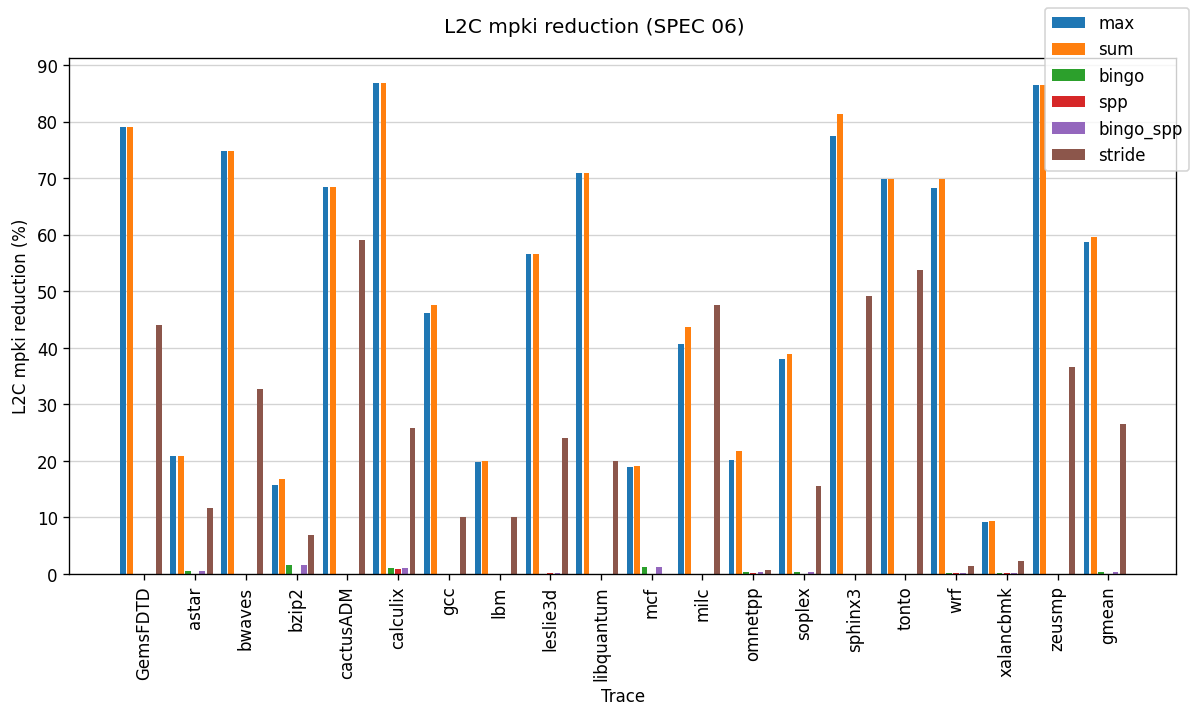

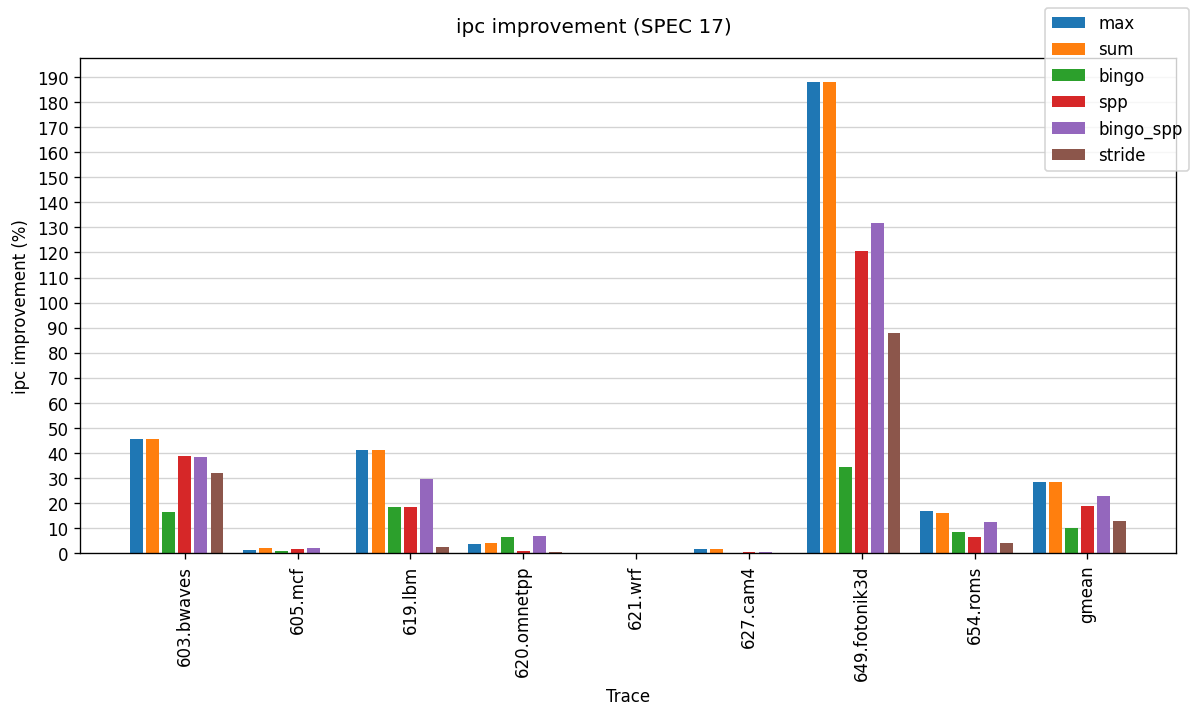

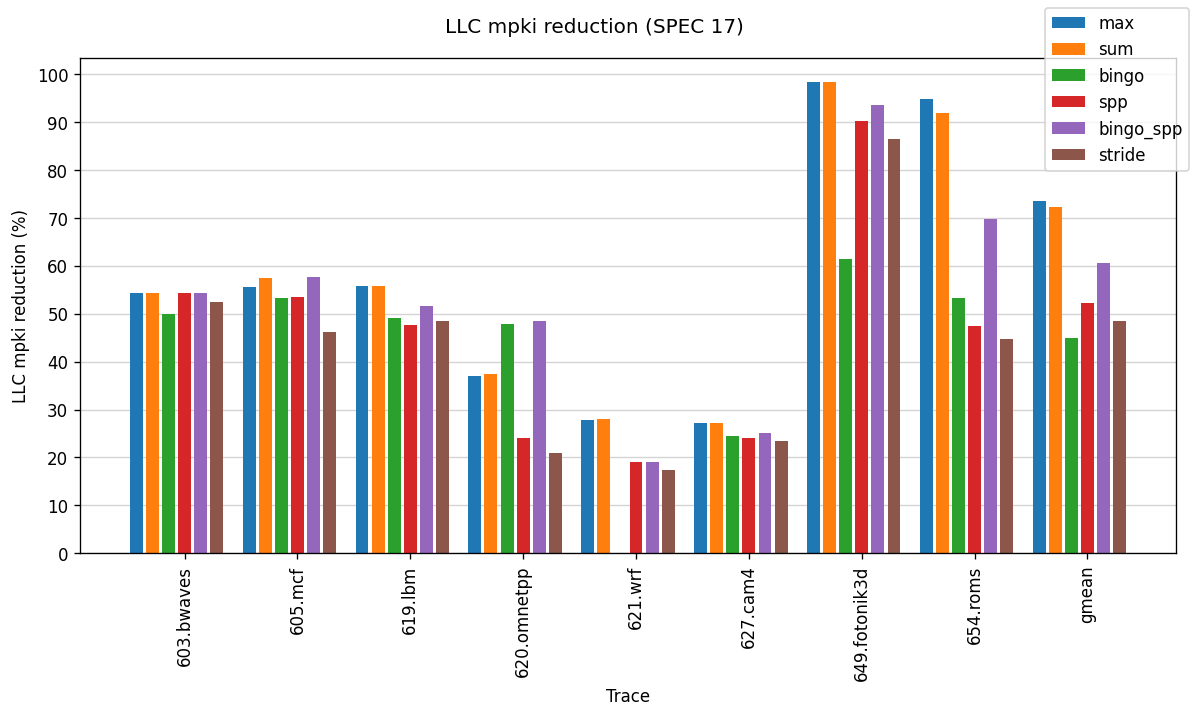

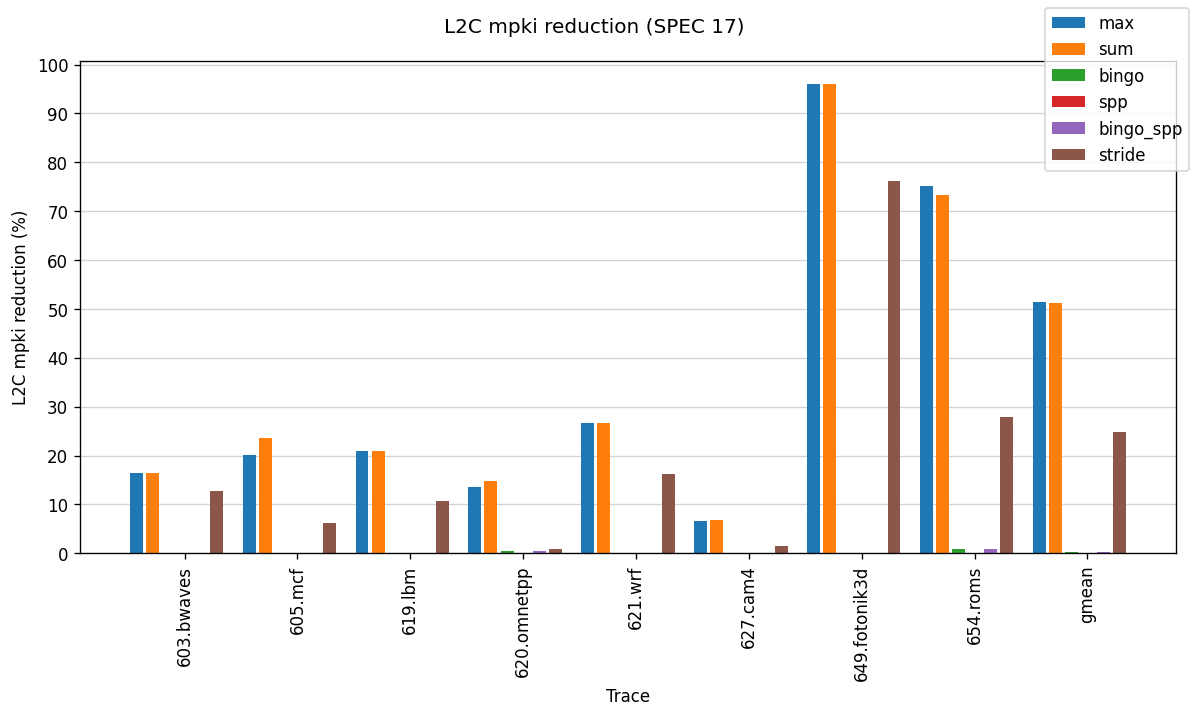

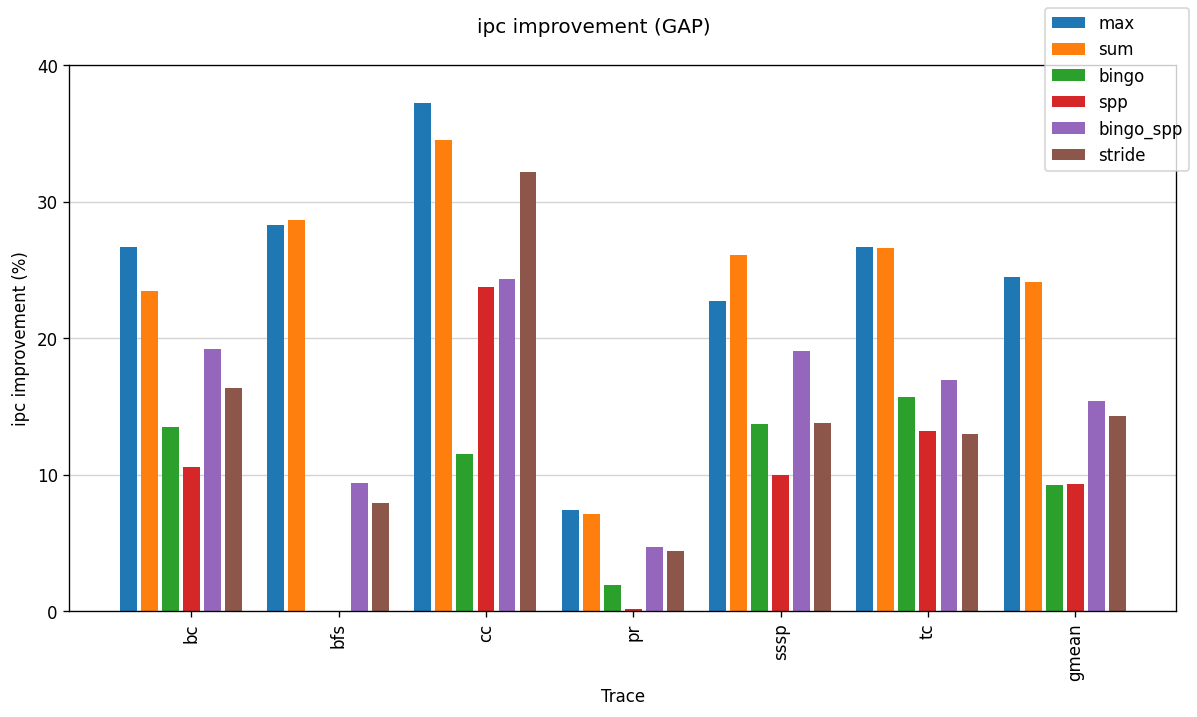

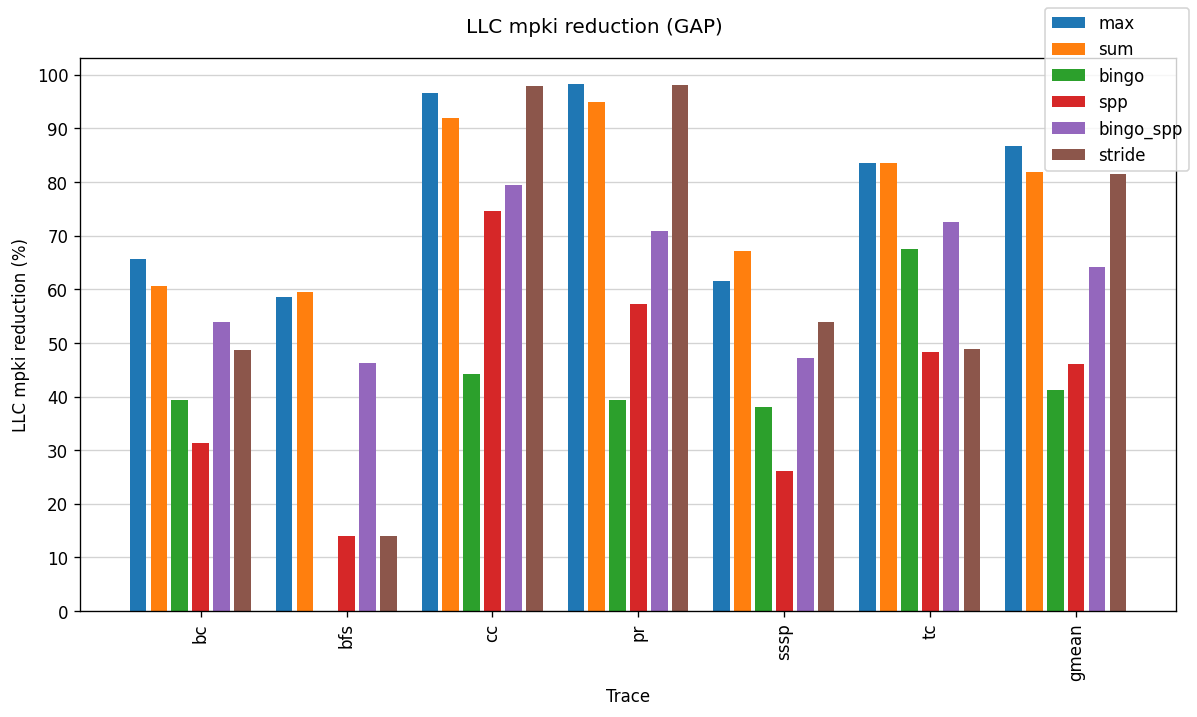

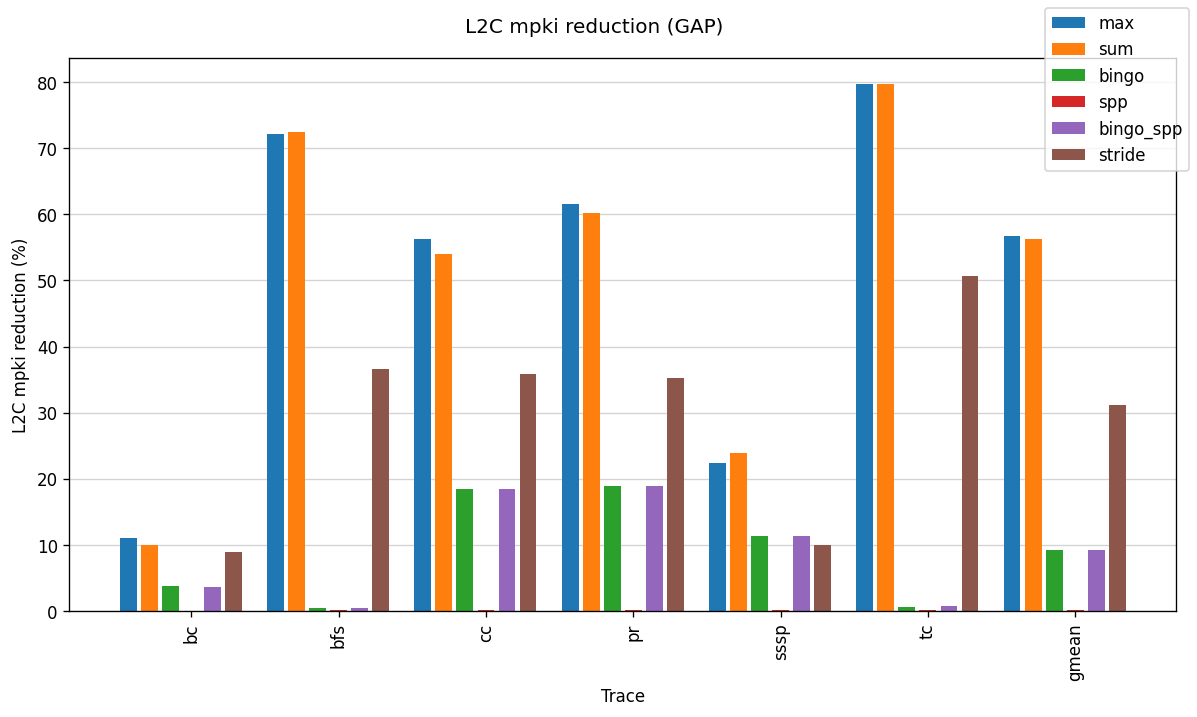

In [10]:
for suite_name, suite in zip(suite_names, suites):
    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    
    print(suite_name)
    for metric in metrics: 
        plot_metric(
            data_df_, metric,
            suite_name=suite_name,
            figsize=(10,6),
            dpi=dpi
        )
        plt.savefig(
            f'{output_dir}/{suite_name}_{metric}_baselines.pdf', 
            bbox_inches='tight'
        )